### Download and process the Dentex training data ###
Full data set: https://zenodo.org/records/7812323/files/training_data.zip

Object detection data: https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz

Dental Enumeration and Diagnosis on Panoramic X-rays

#### DATA ####

The DENTEX dataset comprises panoramic dental X-rays obtained from three different institutions using standard clinical conditions but varying equipment and imaging protocols, resulting in diverse image quality reflecting heterogeneous clinical practice. The dataset includes X-rays from patients aged 12 and above, randomly selected from the hospital's database to ensure patient privacy and confidentiality.

To enable effective use of the FDI system, the dataset is hierarchically organized into three types of data;

(a) 693 X-rays labeled for quadrant detection and quadrant classes only,

(b) 634 X-rays labeled for tooth detection with quadrant and tooth enumeration classes,

(c) 1005 X-rays fully labeled for abnormal tooth detection with quadrant, tooth enumeration, and diagnosis classes.

The diagnosis class includes four specific categories: caries, deep caries, periapical lesions, and impacted teeth. An additional 1571 unlabeled X-rays are provided for pre-training. 

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import json
import copy
from pathlib import Path
import itertools

from matplotlib import pyplot as plt
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xywh2xyxy, xyxy2xywh, clipxywh

print(f'Project module version: {dt.__version__}')

Project module version: 0.0.1.post1.dev16+g367a5b6


### Define data locations for this notebook ###

In [2]:
# Data directory
data_root = os.path.join(os.environ.get('HOME'), 'data')
data_dir = os.path.join(data_root, 'dentex_detection')
model_dir = os.path.join(data_dir, 'model')

Path(data_dir).mkdir(exist_ok=True, parents=True)
Path(model_dir).mkdir(exist_ok=True, parents=True)

# This is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')
print(f'image_dir: {image_dir}')

image_dir: /app/data/dentex_detection/quadrant_enumeration/xrays


### Download Dentex object detection data set from AWS ###

In [3]:
# Download the package from AWS
dtx = DentexData(data_dir=data_dir)
url = dtx.detection_url
print(f'Downloading dentex object detection data from: {url}')

sz = FileOP().file_size_from_url(url)
sz_GB = sz/1.0e9

In [4]:
# Download and extract the data
print(f'Downloading {sz_GB:.2f} GB from:\n{url}')
data_tar_file = dtx.download_image_data(url=url)

# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 634
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Extracted {len(file_list)} images.')

https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz
Extracting from .gz archive.
Uncompressed output file exists: /app/data/dentex_detection/dentex-quadrant-enumeration.tar. Skipping.
Extracted 634 images.


### Functions ###

In [5]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        ax.imshow(image)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=1.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=0.7)
        ax.text(x=anchor[0]+width, y=anchor[1], s=label_list[b], color=boxcolor)
        ax.add_patch(rect)
    ax.set(xticks=[], yticks=[])
    return ax

# Flatten list of lists
def flatten(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))

# Create position number mapping
# FDI - ADA position numbering
def fdi_ada_mapping():
    fdi, ada = [], []
    for q in range(1, 5):
        for p in range(1, 9):
            fdi.append(int(str(q) + str(p)))
        if q in [1, 3]:
            for a in range(8*q, 8*(q-1), -1):
                ada.append(a)
        else:
            for a in range(8*(q-1), 8*q, 1):
                ada.append(a + 1)
    return fdi, ada

# Category mapping
fdi, ada = fdi_ada_mapping()
fdi2ada = dict(zip(fdi, ada))
ada2fdi = {v: k for k, v in fdi2ada.items()}

### Load the annotations into a data frame ###

In [6]:
annotations_file_name = 'train_quadrant_enumeration.json'
annotations_file = os.path.join(data_dir, 
                                'quadrant_enumeration', 
                                annotations_file_name)
annotations = dtx.load_annotations(annotations_file)

# Convert the annotations into a data frame
df = dtx.annotations_to_df()

# The categories are the quadrants and tooth positions
df = df.rename(columns={'category_id_1_name': 'quadrant',
                        'category_id_2_name': 'pos'})

display(df.head(2))

print(f'Number of panoramic x-rays in data set:   {len(df['file_name'].unique())}')
print(f'Total number of annotations in data set:{df.shape[0]}')

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2


Number of panoramic x-rays in data set:   634
Total number of annotations in data set:18095


In [7]:
# Create a (quadrant) bounding box that contains a list of bounding boxes
def compass_box(bbox_list_xywh: list, offset:int) -> list:
    assert isinstance(bbox_list_xywh, list)
    bbox_list_xyxy = [xywh2xyxy(bbox) for bbox in bbox_list_xywh]
    bbox_list_x = flatten([[bbox[0], bbox[2]] for bbox in bbox_list_xyxy])
    bbox_list_y = flatten([[bbox[1], bbox[3]] for bbox in bbox_list_xyxy])
    quadrant_bbox_xywh = xyxy2xywh([min(bbox_list_x)-offset, 
                                    min(bbox_list_y)-offset, 
                                    max(bbox_list_x)+offset, 
                                    max(bbox_list_y)+offset])
    return quadrant_bbox_xywh

train_209.png


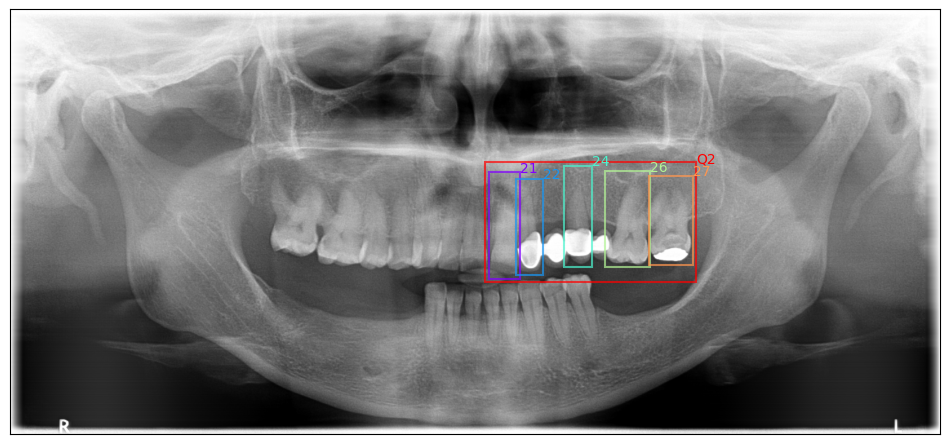

In [8]:
# Let's draw an x-ray image with the bounding boxes in one quadrant
image_idx = 123
quadrant = 2

file_name = sorted(list(df['file_name'].unique()))[image_idx]
print(file_name)

# Load the image
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

df_file = df.loc[(df['file_name'] == file_name) & (df['quadrant'] == quadrant)]

# Get the bounding boxes
box_list_xywh = df_file['bbox'].tolist()
box_list_xywh = [clipxywh(box, xlim=xlim, ylim=ylim, decimals=0) for box in box_list_xywh]

# Tooth positions
pos_list = df_file['pos'].tolist()
pos_list_fdi = [int(f'{quadrant}{pos}') for pos in pos_list]

# Create the quadrant bounding box
# Make the quadrant bounding box just a little bit bigger
quadrant_box_xywh = compass_box(bbox_list_xywh=box_list_xywh, offset=10)


# Show this image with the bounding boxes
bbox_list = copy.deepcopy(box_list_xywh)
bbox_list.append(quadrant_box_xywh)
label_list = copy.deepcopy(pos_list_fdi)
label_list.append(f'Q{quadrant}')
fig, ax = plt.subplots(figsize=(12,6))
ax = show_image_with_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax)